In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe
from jcopml.utils import save_model
from jcopml.plot import plot_missing_value

In [32]:
from luwiji.svm import illustration

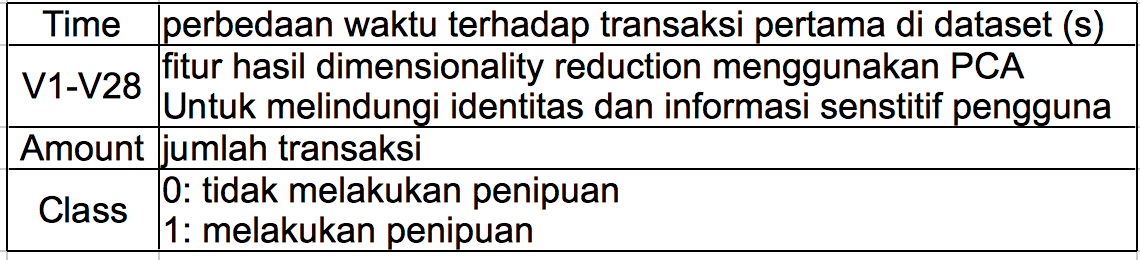

In [33]:
illustration.nomenklatur_cc_fraud

# Import CSV Data

In [34]:
df = pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Cek Missing Value

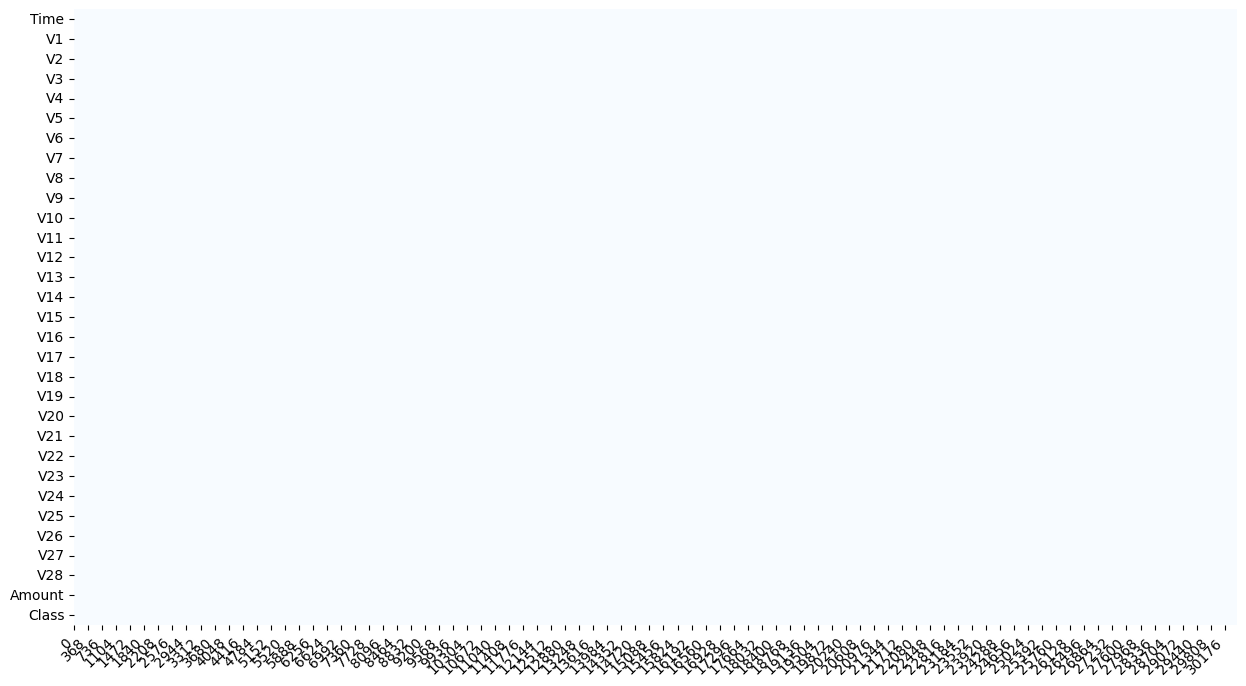

In [35]:
plot_missing_value(df)

# Dataset Splitting

In [36]:
X = df.drop(columns="Class")
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24393, 30), (6099, 30), (24393,), (6099,))

# Pengecekan Dataset apakah balance atau imbalace

In [37]:
df.Class.value_counts()

Class
0    30000
1      492
Name: count, dtype: int64

In [38]:
30000/30492

0.9838646202282566

# Training

In [39]:
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.metrics import f1_score

### Penggunaan ANN dengan hidden layer dan scoring f1

In [42]:
class ANNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_layers=(8, 4), activation='relu', optimizer='adam'):
        self.input_dim = input_dim
        self.activation = activation
        self.hidden_layers = hidden_layers
        self.optimizer = optimizer
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(units=self.input_dim, activation=self.activation))
        model.add(Dense(units=self.hidden_layers[0], activation=self.activation))
        model.add(Dense(units=self.hidden_layers[1], activation=self.activation))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=[BinaryAccuracy()])
        return model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        self.classes_ = np.unique(y)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)
    
    def predict_proba(self, X):
        return self.model.predict(X)

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X_train.columns),
    ])

model = Pipeline([
    ('prep', preprocessor),
    ('algo', ANNClassifier(input_dim=len(X_train.columns)))
])

model.fit(X_train, y_train)

train_f1_score = f1_score(y_train, model.predict(X_train))
print("Train F1 Score:", train_f1_score)

test_f1_score = f1_score(y_test, model.predict(X_test))
print("Test F1 Score:", test_f1_score)

763/763 [==============================] - 1s 1ms/step
Train F1 Score: 0.9617755856966708
191/191 [==============================] - 0s 1ms/step
Test F1 Score: 0.926829268292683
